In [1]:
import networkx as nx
import torch
import pandas as pd
import itertools
from torch_geometric.utils import from_networkx
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.utils import negative_sampling, train_test_split_edges
from sklearn.metrics import roc_auc_score, average_precision_score
from torch_geometric.loader import LinkNeighborLoader
import torch_geometric.transforms as T
import pyg_lib
from torch import Tensor
from torch_geometric.nn import SAGEConv
import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import NNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.data import Data

In [2]:
def explode_combinations_with_inparalogs(df, cols_to_explode,
                                         protein_col='protein/inparalogs',
                                         ortholog_col='orthologs',
                                         taxid_col='taxid',
                                         ortholog_taxid_col='ortholog_taxid'):
    for col in cols_to_explode:
        df[col] = df[col].str.split(',')
    df_expanded = df.copy()
    for col in cols_to_explode:
        df_expanded = df_expanded.explode(col, ignore_index=True)
    new_rows = []
    for _, row in df.iterrows():
        proteins = row[protein_col]
        taxid = row[taxid_col]
        if isinstance(proteins, list) and len(proteins) > 1:
            for p1, p2 in itertools.combinations(proteins, 2):
                new_rows.append({
                    taxid_col: taxid,
                    protein_col: p1,
                    ortholog_col: p2,
                    ortholog_taxid_col: taxid
                })
    if new_rows:
        df_expanded_inpara = pd.DataFrame(new_rows, columns=["taxid", "protein/inparalogs", "orthologs", "ortholog_taxid"])
    return df_expanded, df_expanded_inpara

def graph_summary(G, cc):
    print("Nombre de nœuds : ", G.number_of_nodes())
    print("Nombre d’arêtes : ", G.number_of_edges())

    print("Nombre de composantes connexes : ", len(cc))
    print(f"Composante la plus grande : ", len(max(cc, key=len)))



def ortho_graph_total(path_taxid):

    #Importe liste des espèces
    id_list = []
    with open(path_taxid) as id_file:
        for l in id_file:
            id_list.append(int(l.strip()))
    print("Chargement : ", len(id_list), " espèces")

    #Importe fichiers d'orthologies
    df_ortho = pd.DataFrame(columns=["taxid", "protein/inparalogs", "orthologs", "ortholog_taxid"])
    for id in id_list:
        df = pd.read_csv("/home/schoenstein/these/test_gnn/data/" + str(id) + ".tsv", sep = "\t")
        df = df[df['ortholog_taxid'].isin(id_list)]
        df["taxid"] = id
        df_ortho = pd.concat([df_ortho, df], ignore_index = True)
    
    #Etale les paralogues
    cols_to_explode = ['protein/inparalogs', 'orthologs']
    df_ortho_split, df_inpara_split = explode_combinations_with_inparalogs(df_ortho, cols_to_explode)
    print(df_ortho_split)
    print("Chargement : ", len(df_ortho_split), " relations")

    #Crée graphe
    edges_ortho = list(zip(df_ortho_split['protein/inparalogs'], df_ortho_split['orthologs']))
    edges_inpara = list(zip(df_inpara_split['protein/inparalogs'], df_inpara_split['orthologs']))
    G = nx.Graph()
    G.add_edges_from(edges_ortho, label = "ortho")
    G.add_edges_from(edges_inpara, label = "inpara")

    #Attribue les espèces à chaque noeud
    node_taxid = pd.concat([
        df_ortho_split[['protein/inparalogs','taxid']].rename(columns={'protein/inparalogs':'node','taxid':'taxid'}),
        df_ortho_split[['orthologs','ortholog_taxid']].rename(columns={'orthologs':'node','ortholog_taxid':'taxid'})
    ])
    node_taxid_dict = pd.Series(node_taxid['taxid'].values, index=node_taxid['node']).to_dict()
    nx.set_node_attributes(G, node_taxid_dict, name='taxid')

    #Composantes connexes et leurs tailles
    cc = sorted(list(nx.connected_components(G)), key = len, reverse = True)
    list_taille = []
    for c in cc:
        list_taille.append(len(c))

    #Statistiques de base du graph
    graph_summary(G, cc)

    return G

In [3]:
G = ortho_graph_total("/home/schoenstein/these/test_gnn/id_list_metazoa_reduce.txt")

Chargement :  3  espèces
      taxid protein/inparalogs   orthologs ortholog_taxid
0      7741         A0A6P5AHG9      W5LZN0           7918
1      7741         A0A6P5AMR1      W5M0K9           7918
2      7741         A0A6P4ZUP5      W5M1I4           7918
3      7741         A0A6P4YNN3      W5M5L0           7918
4      7741         A0A6P5AKH2      W5M5R0           7918
...     ...                ...         ...            ...
83509  7918             W5N1A9  A0A6P4ZN16           7741
83510  7918             W5MVK8      Q9U637           7741
83511  7918             W5MVK8  A0A6P4ZN16           7741
83512  7918             W5MTI1      Q9U637           7741
83513  7918             W5MTI1  A0A6P4ZN16           7741

[83514 rows x 4 columns]
Chargement :  83514  relations
Nombre de nœuds :  38862
Nombre d’arêtes :  63847
Nombre de composantes connexes :  11015
Composante la plus grande :  103


In [4]:
data = from_networkx(G)


In [5]:
print(data)

Data(edge_index=[2, 127694], taxid=[38862], label=[127694], num_nodes=38862)


In [ ]:
species = [G.nodes[n]['taxid'] for n in G.nodes()]
species_tensor = torch.tensor(LabelEncoder().fit_transform(species), dtype=torch.long)
species_one_hot = F.one_hot(species_tensor).float()
data.x = species_one_hot

edge_labels = [G.edges[e]['label'] for e in G.edges()]
edge_tensor = torch.tensor(LabelEncoder().fit_transform(edge_labels), dtype=torch.long)
edge_label_tensor = torch.cat([edge_tensor, edge_tensor], dim=0)
edge_one_hot = F.one_hot(edge_label_tensor).float()
data.edge_type = edge_one_hot


for key in list(data.keys()):
    if key not in ['x', 'edge_index', 'edge_type']:
        del data[key]

In [7]:
print(data)

Data(edge_index=[2, 127694], x=[38862, 3], edge_type=[127694, 2])


In [8]:
transform = T.RandomLinkSplit(
    num_val= 0.1,  
    num_test= 0.1,  
    disjoint_train_ratio= 0.3,  
    neg_sampling_ratio= 2,
    is_undirected = True
)

train_data, val_data, test_data = transform(data)
print("Training data:")
print("==============")
print(train_data)
print()
print("Validation data:")
print("================")
print(val_data)

Training data:
Data(edge_index=[2, 71512], x=[38862, 3], edge_type=[71512, 2], edge_label=[45969], edge_label_index=[2, 45969])

Validation data:
Data(edge_index=[2, 102158], x=[38862, 3], edge_type=[102158, 2], edge_label=[19152], edge_label_index=[2, 19152])


In [12]:
train_loader = LinkNeighborLoader(
    data = train_data,  
    num_neighbors = [20,10],  
    #neg_sampling_ratio = 2,  
    neg_sampling_ratio = 1,  
    edge_label_index=train_data.edge_label_index,
    edge_label=train_data.edge_label,
    batch_size=128,
    shuffle=True,
)
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio = 0,
    edge_label_index=val_data.edge_label_index,
    edge_label=val_data.edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

GNN sans attributs arrêtes 

In [ ]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()

        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x: Tensor, edge_label_index: Tensor) -> Tensor:
        edge_feat_src = x[edge_label_index[0]]
        edge_feat_dst = x[edge_label_index[1]]

        # Normalisation L2 de chaque embedding pour limiter l'explosion du dot-product
        edge_feat_src = F.normalize(edge_feat_src, dim=-1)
        edge_feat_dst = F.normalize(edge_feat_dst, dim=-1)

        pred = (edge_feat_src * edge_feat_dst).sum(dim=-1)
        return pred
    
class Model(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.gnn = GNN(in_channels, hidden_channels)
        self.classifier = Classifier()

    def forward(self, data) -> Tensor:
        x = self.gnn(data.x, data.edge_index)
        pred = self.classifier(x, data.edge_label_index)
        return pred

model = Model(in_channels = train_data.x.shape[1], hidden_channels=64)

print(model)

GNN avec attributs sur les arrêtes

In [ ]:
# GNN avec NNConv pour prendre en compte edge_attr
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, edge_dim):
        super().__init__()
        # MLP pour transformer les features d'arêtes
        nn1 = Sequential(Linear(edge_dim, in_channels * hidden_channels), ReLU())
        nn2 = Sequential(Linear(edge_dim, hidden_channels * hidden_channels), ReLU())
        
        self.conv1 = NNConv(in_channels, hidden_channels, nn1, aggr='mean')
        self.conv2 = NNConv(hidden_channels, hidden_channels, nn2, aggr='mean')

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor) -> Tensor:
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return x

# Classifier identique à ton code original
class Classifier(torch.nn.Module):
    def forward(self, x: Tensor, edge_label_index: Tensor) -> Tensor:
        edge_feat_src = x[edge_label_index[0]]
        edge_feat_dst = x[edge_label_index[1]]

        # Normalisation L2
        edge_feat_src = F.normalize(edge_feat_src, dim=-1)
        edge_feat_dst = F.normalize(edge_feat_dst, dim=-1)

        pred = (edge_feat_src * edge_feat_dst).sum(dim=-1)
        return pred

# Modèle complet
class Model(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, edge_dim):
        super().__init__()
        self.gnn = GNN(in_channels, hidden_channels, edge_dim=edge_dim)
        self.classifier = Classifier()

    def forward(self, data) -> Tensor:
        x = self.gnn(data.x, data.edge_index, data.edge_type)
        pred = self.classifier(x, data.edge_label_index)
        return pred


#model = Model(in_channels=train_data.x.shape[1], hidden_channels=158, edge_dim=train_data.edge_type.shape[1])

#print(model)


In [ ]:
for x in [64, 158]:
    model = Model(in_channels=train_data.x.shape[1], hidden_channels=x, edge_dim=train_data.edge_type.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

    for epoch in range(1, 4):
        total_loss = []
        for sampled_data in tqdm.tqdm(train_loader):
            optimizer.zero_grad()
            pred = model(sampled_data)
            y = sampled_data.edge_label.float()
            loss = F.binary_cross_entropy_with_logits(pred, y)
            loss.backward()
            optimizer.step()
            total_loss.append(float(loss))
        loss_total = np.mean(total_loss)
        preds = []
        ground_truths = []
        model.eval()
        total_val_loss = []
        for sampled_data in tqdm.tqdm(val_loader):
            with torch.no_grad():
                pred = model(sampled_data)
                y = sampled_data.edge_label.float()
                preds.append(pred)
                ground_truths.append(y)
                val_loss = F.binary_cross_entropy_with_logits(pred, y)
                total_val_loss.append(float(val_loss))
        pred = torch.cat(preds, dim=0).numpy()
        ground_truth = torch.cat(ground_truths, dim=0).numpy()
        val_loss_total = np.mean(total_val_loss)
        auc = roc_auc_score(ground_truth, pred)
        print(f"epoch {epoch:03d} | train loss {loss_total:.4f} | val AUC {auc:.4f} | val loss {val_loss_total:.4f}")
    path  = "trained_model" + str(x) + ".pt"
    torch.save(model, path)

  0%|          | 0/360 [00:00<?, ?it/s]

100%|██████████| 50/50 [03:47<00:00,  4.55s/it]


epoch 001 | train loss 0.5933 | val AUC 0.8876 | val loss 0.6914


100%|██████████| 50/50 [03:52<00:00,  4.64s/it]


epoch 002 | train loss 0.5554 | val AUC 0.9217 | val loss 0.6309


100%|██████████| 50/50 [03:49<00:00,  4.58s/it]


epoch 003 | train loss 0.5474 | val AUC 0.9331 | val loss 0.6259


100%|██████████| 50/50 [00:51<00:00,  1.02s/it]


epoch 001 | train loss 0.5980 | val AUC 0.8822 | val loss 0.7003


100%|██████████| 50/50 [04:26<00:00,  5.33s/it]


epoch 002 | train loss 0.5560 | val AUC 0.9260 | val loss 0.6318


100%|██████████| 50/50 [04:30<00:00,  5.41s/it]

epoch 003 | train loss 0.5478 | val AUC 0.9353 | val loss 0.6229


code type pour validation

In [13]:
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio = 0,
    edge_label_index=val_data.edge_label_index,
    edge_label=val_data.edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        pred = model(sampled_data)
        y = sampled_data.edge_label.float()
        preds.append(pred)
        ground_truths.append(y)

pred = torch.cat(preds, dim=0).numpy()
ground_truth = torch.cat(ground_truths, dim=0).numpy()
auc = roc_auc_score(ground_truth, pred)
print(f"Validation AUC: {auc:.4f}")

100%|██████████| 50/50 [01:05<00:00,  1.31s/it]

Validation AUC: 0.9256


In [ ]:
prob = 1 / (1 + np.exp(-pred))

y_pred = (prob > 0.7).astype(int) #0.7 : seuil arbitraire
y_true = ground_truth.astype(int)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

Precision: 0.8653
Recall:    0.7273
F1-score:  0.7903


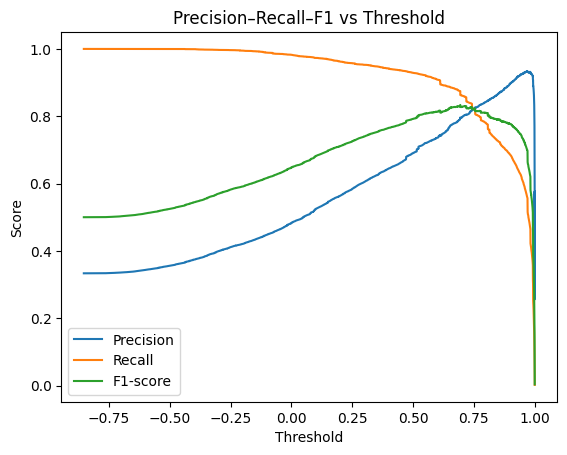

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(ground_truth, pred)
f1 = 2 * (precision * recall) / (precision + recall)

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.plot(thresholds, f1[:-1], label="F1-score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision–Recall–F1 vs Threshold")
plt.show()



In [3]:
G2 = ortho_graph_total("/home/schoenstein/these/test_gnn/id_list_metazoa_reduce2.txt")
data2 = from_networkx(G2)
species = [G2.nodes[n]['taxid'] for n in G2.nodes()]
species_tensor = torch.tensor(LabelEncoder().fit_transform(species), dtype=torch.long)
species_one_hot = F.one_hot(species_tensor).float()
data2.x = species_one_hot

edge_labels = [G2.edges[e]['label'] for e in G2.edges()]
edge_tensor = torch.tensor(LabelEncoder().fit_transform(edge_labels), dtype=torch.long)
edge_label_tensor = torch.cat([edge_tensor, edge_tensor], dim=0)
edge_one_hot = F.one_hot(edge_label_tensor).float()
data2.edge_type = edge_one_hot


for key in list(data2.keys()):
    if key not in ['x', 'edge_index', 'edge_type']:
        del data2[key]

print(data2)

Chargement :  3  espèces
        taxid protein/inparalogs   orthologs ortholog_taxid
0       31033             H2V8F6      A0A182           7955
1       31033             H2V9W2  A0A286Y8B5           7955
2       31033             H2TMA1  A0A8M1N2B9           7955
3       31033         A0A3B5K4M3  A0A8M1N6K4           7955
4       31033             H2RKR8  A0A8M1NF74           7955
...       ...                ...         ...            ...
116291  27687         A0A8C4SMW3  A0A674MSB8          31033
116292  27687         A0A8C4SMW3  A0A674PKF2          31033
116293  27687         A0A8C4SMW3  A0A674N736          31033
116294  27687         A0A8C4SMW3  A0A674NFW3          31033
116295  27687         A0A8C4SMW3  A0A3B5KT58          31033

[116296 rows x 4 columns]
Chargement :  116296  relations
Nombre de nœuds :  52379
Nombre d’arêtes :  104879
Nombre de composantes connexes :  16027
Composante la plus grande :  298
Data(edge_index=[2, 209758], x=[52379, 3], edge_type=[209758, 2])


In [ ]:
edge_label_index = negative_sampling(edge_index = data2.edge_index, num_nodes = data2.x.size(0), num_neg_samples = 100000000)
data2.edge_label_index = edge_label_index
model = torch.load("trained_model.pt")
with torch.no_grad():
    pred = model(data2)
proba = torch.sigmoid(pred)

pred_df = pd.DataFrame({
    "node1": edge_label_index[0].numpy(),
    "node2": edge_label_index[1].numpy(),
    "score": proba.numpy()
}).sort_values("score", ascending=False)

print(pred_df.head(10))

/tmp/ipykernel_812350/2648800099.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("trained_model.pt")


          node1  node2     score
24126634  14552  13116  0.731009
33056301  39809  42697  0.730970
34087268  31358  51854  0.730954
80930908  49794  48068  0.730913
20631797  49819  20714  0.730912
96693668  30928  31354  0.730908
77384518  31354  30928  0.730908
925046     6819  11619  0.730904
79205759  31324  51870  0.730902
88793354  51889  31359  0.730896


In [44]:
idx_to_node = dict(enumerate(G2.nodes()))
pred_df["node1"] = pred_df["node1"].map(idx_to_node)
pred_df["node2"] = pred_df["node2"].map(idx_to_node)

In [ ]:
cc = sorted(list(nx.connected_components(G2)), key = len, reverse = True)

node_to_cc = {}
for i, cc_nodes in enumerate(cc):
    for n in cc_nodes:
        node_to_cc[n] = i

pred_df['component1'] = pred_df['node1'].map(node_to_cc)
pred_df['component2'] = pred_df['node2'].map(node_to_cc)


In [46]:
print(pred_df.head(10))

               node1       node2     score  component1  component2
24126634  A0A3B5K6G1      H2UR24  0.731009       13848       13781
33056301  A0A8C4SNQ4  A0A8C4S6N1  0.730970       14703       14775
34087268  A0A8M6Z008  A0A8M6YY09  0.730954           0           0
80930908  A0A8C4SYN9  A0A8C4TE48  0.730913       15759       15062
20631797  A0A8C4S1V0      H2TTN8  0.730912       10832       10832
96693668  A0A8M9QC89  A0A8M9PV76  0.730908           4           0
77384518  A0A8M9PV76  A0A8M9QC89  0.730908           0           4
925046    A0A2R8QUQ1      Q5EG55  0.730904       13461       13705
79205759  A0A8M6YZT0  A0A8M3AUG8  0.730902           0           0
88793354  A0A8M9PQ13  A0A8M9Q7H7  0.730896           0           0


In [47]:
pred_df_same = pred_df[pred_df['component1'] == pred_df['component2']]

In [54]:
pred_df_same.to_csv("prediction_same_cc.csv")

In [53]:
print(pred_df_same)

               node1       node2     score  component1  component2
34087268  A0A8M6Z008  A0A8M6YY09  0.730954           0           0
20631797  A0A8C4S1V0      H2TTN8  0.730912       10832       10832
79205759  A0A8M6YZT0  A0A8M3AUG8  0.730902           0           0
88793354  A0A8M9PQ13  A0A8M9Q7H7  0.730896           0           0
13176167  A0A8M6YYD2  A0A8M9Q7H7  0.730875           0           0
...              ...         ...       ...         ...         ...
95822786  A0A8C4SMR3  A0A8C4TAE6  0.370277        1754        1754
234467    A0A8M2BF59  A0A8M3AL55  0.369641         511         511
94272579  A0A0E4G213      Q6P695  0.362741         159         159
65600291      H2RQ54      Q9DFS6  0.360844         335         335
6743959   A0A8C4XBX7      H2SHT3  0.344924         184         184

[2678 rows x 5 columns]


In [4]:
pred_df_same = pd.read_csv("/home/schoenstein/these/test_gnn/prediction_same_cc.csv")

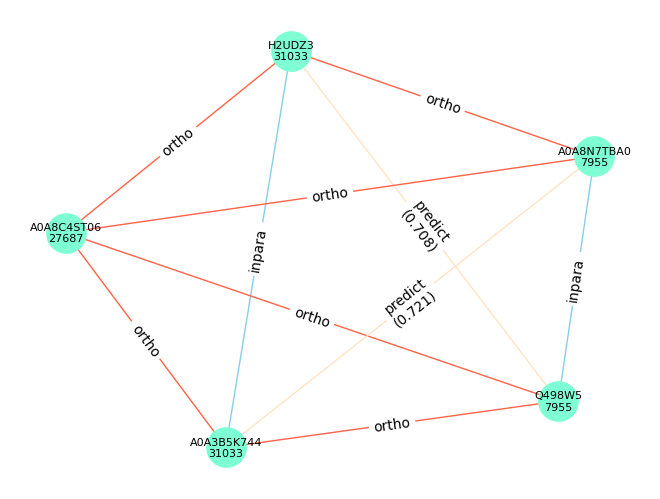

In [9]:
interest = cc[589]
sub = G2.subgraph(interest).copy()
pred_edges = pred_df_same[pred_df_same['component1'] == 589]
for _, row in pred_edges.iterrows():
    sub.add_edge(row["node1"], row["node2"], label="predict", score=row["score"])

pos = nx.spring_layout(sub, seed=42)

edge_colors = []
for _, _, data_edge in sub.edges(data=True):
    if data_edge.get("label") == "ortho":
        edge_colors.append("tomato")
    elif data_edge.get("label") == "inpara":
        edge_colors.append("skyblue")
    elif data_edge.get("label") == "predict":
        edge_colors.append("bisque")

nx.draw(
    sub,
    pos,
    edge_color= edge_colors,
    node_color="aquamarine",
    node_size=800,
    font_size=8
)

edge_labels = {}
for u, v, data_edge in sub.edges(data=True):
    label = data_edge.get("label")
    if label == "predict":
        score = data_edge.get("score")
        edge_labels[(u, v)] = f"{label}\n({score:.3f})"
    else:
        edge_labels[(u, v)] = label
nx.draw_networkx_edge_labels(sub, pos, edge_labels=edge_labels, font_color="black")

node_labels = nx.get_node_attributes(sub, "taxid")
merged_labels = {n: f"{n}\n{attr}" for n, attr in node_labels.items()}
nx.draw_networkx_labels(sub, pos, labels=merged_labels, font_size=8)

plt.show()

In [4]:
predictions = pd.read_csv("/home/schoenstein/these/test_gnn/prediction.csv")
print(predictions)

          Unnamed: 0       node1       node2     score  component
0           25912157  A0A8C4RFY6  A0A8C4RKV5  0.731042       4077
1           45990140      Q6NZ30  A0A8M2B3Q0  0.731020      13843
2           12611055  A0A8M6Z008  A0A8M9PCI1  0.730947          0
3            4832061      Q6L6X6      H2U6J6  0.730939      13559
4           50742769  A0A8M1P0G4      Q6PC91  0.730929      15979
...              ...         ...         ...       ...        ...
99999995    25976538      A5PMW0      Q7ZTI5  0.284373       2184
99999996    40986671  A0A8C4TJP4      Q567X6  0.283506        953
99999997    47386164  A0A8C4X4W8  A0A8M3B2G3  0.283425        553
99999998    90877578      Q6IQ88      Q90YC5  0.282792      10619
99999999    66906721      Q567X6      A5PMW0  0.281966       6734

[100000000 rows x 5 columns]


In [7]:
cc = sorted(list(nx.connected_components(G2)), key = len, reverse = True)

node_to_cc = {}
for i, cc_nodes in enumerate(cc):
    for n in cc_nodes:
        node_to_cc[n] = i
predictions['component2'] = predictions['node2'].map(node_to_cc)

In [9]:
predictions = predictions.drop(columns=['Unnamed: 0'])

In [10]:
print(predictions)

               node1       node2     score  component  component2
0         A0A8C4RFY6  A0A8C4RKV5  0.731042       4077        7976
1             Q6NZ30  A0A8M2B3Q0  0.731020      13843       13869
2         A0A8M6Z008  A0A8M9PCI1  0.730947          0           0
3             Q6L6X6      H2U6J6  0.730939      13559       14230
4         A0A8M1P0G4      Q6PC91  0.730929      15979       15268
...              ...         ...       ...        ...         ...
99999995      A5PMW0      Q7ZTI5  0.284373       2184        4464
99999996  A0A8C4TJP4      Q567X6  0.283506        953        6734
99999997  A0A8C4X4W8  A0A8M3B2G3  0.283425        553        7866
99999998      Q6IQ88      Q90YC5  0.282792      10619         611
99999999      Q567X6      A5PMW0  0.281966       6734        2184

[100000000 rows x 5 columns]


In [ ]:
id_list = []
with open("/home/schoenstein/these/test_gnn/id_list_metazoa_reduce2.txt") as id_file:
    for l in id_file:
        id_list.append(int(l.strip()))
dico_map = {}
for id in id_list:
    df_ortho = pd.DataFrame(columns=["taxid", "protein/inparalogs", "orthologs", "ortholog_taxid"])
    df = pd.read_csv("/home/schoenstein/these/test_gnn/data/" + str(id) + ".tsv", sep = "\t")
    df = df[df['ortholog_taxid'].isin(id_list)]
    df["taxid"] = id
    df_ortho = pd.concat([df_ortho, df], ignore_index = True)
    list_gen = []
    for i in range(0, len(df_ortho)):
        split = df_ortho.loc[i, "protein/inparalogs"].split(",")
        if len(split) > 1:
            for x in split:
                list_gen.append(x)
        else:
            list_gen.append(df_ortho.loc[i, "protein/inparalogs"])
    dico_map[id] = list_gen
print(dico_map)

dict_keys([31033, 7955, 27687])


In [19]:
predictions_cut = predictions[predictions['score'] > 0.6]

In [22]:
print(predictions_cut)

               node1       node2     score  component  component2
0         A0A8C4RFY6  A0A8C4RKV5  0.731042       4077        7976
1             Q6NZ30  A0A8M2B3Q0  0.731020      13843       13869
2         A0A8M6Z008  A0A8M9PCI1  0.730947          0           0
3             Q6L6X6      H2U6J6  0.730939      13559       14230
4         A0A8M1P0G4      Q6PC91  0.730929      15979       15268
...              ...         ...       ...        ...         ...
27159392      H2SB43      H2RSA0  0.600000       5438        6988
27159393  A0A8C4T9D3      H2RW23  0.600000       6168        7021
27159394  A0A8C4X8M4      E7FBF7  0.600000       5318       10300
27159395  A0A8C4S0M6  A0A674N1A1  0.600000       1650        2782
27159396  A0A8C4RMD0  A0A8M9QBR5  0.600000       3915        2877

[27159397 rows x 5 columns]


In [24]:
predictions_cut["taxid_1"] = predictions_cut["node1"].apply(lambda n: G2.nodes[n]["taxid"])
predictions_cut["taxid_2"] = predictions_cut["node2"].apply(lambda n: G2.nodes[n]["taxid"])

/tmp/ipykernel_444450/2576298309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_cut["taxid_1"] = predictions_cut["node1"].apply(lambda n: G2.nodes[n]["taxid"])
/tmp/ipykernel_444450/2576298309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_cut["taxid_2"] = predictions_cut["node2"].apply(lambda n: G2.nodes[n]["taxid"])


In [26]:
print(predictions_cut)

               node1       node2     score  component  component2  taxid_1  \
0         A0A8C4RFY6  A0A8C4RKV5  0.731042       4077        7976    27687   
1             Q6NZ30  A0A8M2B3Q0  0.731020      13843       13869     7955   
2         A0A8M6Z008  A0A8M9PCI1  0.730947          0           0     7955   
3             Q6L6X6      H2U6J6  0.730939      13559       14230    31033   
4         A0A8M1P0G4      Q6PC91  0.730929      15979       15268     7955   
...              ...         ...       ...        ...         ...      ...   
27159392      H2SB43      H2RSA0  0.600000       5438        6988    31033   
27159393  A0A8C4T9D3      H2RW23  0.600000       6168        7021    27687   
27159394  A0A8C4X8M4      E7FBF7  0.600000       5318       10300    27687   
27159395  A0A8C4S0M6  A0A674N1A1  0.600000       1650        2782    27687   
27159396  A0A8C4RMD0  A0A8M9QBR5  0.600000       3915        2877    27687   

          taxid_2  
0           27687  
1            7955  
2  

In [27]:
predictions_cut["type"] = np.where(predictions_cut["taxid_1"] == predictions_cut["taxid_2"],"inpara","ortho")

/tmp/ipykernel_444450/3556383628.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_cut["type"] = np.where(predictions_cut["taxid_1"] == predictions_cut["taxid_2"],"inpara","ortho")


In [28]:
print(predictions_cut)

               node1       node2     score  component  component2  taxid_1  \
0         A0A8C4RFY6  A0A8C4RKV5  0.731042       4077        7976    27687   
1             Q6NZ30  A0A8M2B3Q0  0.731020      13843       13869     7955   
2         A0A8M6Z008  A0A8M9PCI1  0.730947          0           0     7955   
3             Q6L6X6      H2U6J6  0.730939      13559       14230    31033   
4         A0A8M1P0G4      Q6PC91  0.730929      15979       15268     7955   
...              ...         ...       ...        ...         ...      ...   
27159392      H2SB43      H2RSA0  0.600000       5438        6988    31033   
27159393  A0A8C4T9D3      H2RW23  0.600000       6168        7021    27687   
27159394  A0A8C4X8M4      E7FBF7  0.600000       5318       10300    27687   
27159395  A0A8C4S0M6  A0A674N1A1  0.600000       1650        2782    27687   
27159396  A0A8C4RMD0  A0A8M9QBR5  0.600000       3915        2877    27687   

          taxid_2    type  
0           27687  inpara  
1      

In [30]:
o_count = (predictions_cut['type'] == "ortho").sum()
print("Orthologues : ", o_count, " Paralogues : ", len(predictions_cut) - o_count)
cc_count = (predictions_cut['component'] == predictions_cut['component2']).sum()
print("Même composante : ", cc_count, " Vers une autre composante : ", len(predictions_cut) - cc_count)

Orthologues :  14948340  Paralogues :  12211057
Même composante :  1458  Vers une autre composante :  27157939


In [31]:
predictions_cut.to_csv("prediction_06.csv", index = False)

Prédiction ausein des connected components

In [10]:
G2 = ortho_graph_total("/home/schoenstein/these/test_gnn/id_list_metazoa_reduce2.txt")
cc = sorted(list(nx.connected_components(G2)), key = len, reverse = True)
pred_df_list = []
for i, c in enumerate(cc):
    G3 = G2.subgraph(c).copy()
    max_edges = (G3.number_of_nodes() * (G3.number_of_nodes() -1))/2
    if G3.number_of_edges() < max_edges:
        data3 = from_networkx(G3)
        species = [G3.nodes[n]['taxid'] for n in G3.nodes()]
        species_tensor = torch.tensor(LabelEncoder().fit_transform(species), dtype=torch.long)
        species_one_hot = F.one_hot(species_tensor, num_classes=3).float()
        data3.x = species_one_hot
        edge_labels = [G3.edges[e]['label'] for e in G3.edges()]
        edge_tensor = torch.tensor(LabelEncoder().fit_transform(edge_labels), dtype=torch.long)
        edge_label_tensor = torch.cat([edge_tensor, edge_tensor], dim=0)
        edge_one_hot = F.one_hot(edge_label_tensor, num_classes=2).float()
        data3.edge_type = edge_one_hot

        for key in list(data3.keys()):
            if key not in ['x', 'edge_index', 'edge_type']:
                del data3[key]
        no_edge_remaining = int((max_edges * 2) - (G3.number_of_edges()*2))
        edge_label_index = negative_sampling(edge_index = data3.edge_index, num_nodes = data3.x.size(0), num_neg_samples = no_edge_remaining)
        data3.edge_label_index = edge_label_index
        model = torch.load("trained_model158.pt", weights_only=False)
        with torch.no_grad():
            pred = model(data3)
        proba = torch.sigmoid(pred)
        pred_df = pd.DataFrame({"node1": edge_label_index[0].numpy(), "node2": edge_label_index[1].numpy(), "score": proba.numpy()}).sort_values("score", ascending=False)
        idx_to_node = dict(enumerate(G3.nodes()))
        pred_df["node1"] = pred_df["node1"].map(idx_to_node)
        pred_df["node2"] = pred_df["node2"].map(idx_to_node)
        pred_df["taxid_1"] = pred_df["node1"].apply(lambda n: G2.nodes[n]["taxid"])
        pred_df["taxid_2"] = pred_df["node2"].apply(lambda n: G2.nodes[n]["taxid"])
        pred_df["type"] = np.where(pred_df["taxid_1"] == pred_df["taxid_2"],"inpara","ortho")
        pred_df_list.append(pred_df)
pred_df_total = pd.concat(pred_df_list, ignore_index = True)


Chargement :  3  espèces
        taxid protein/inparalogs   orthologs ortholog_taxid
0       31033             H2V8F6      A0A182           7955
1       31033             H2V9W2  A0A286Y8B5           7955
2       31033             H2TMA1  A0A8M1N2B9           7955
3       31033         A0A3B5K4M3  A0A8M1N6K4           7955
4       31033             H2RKR8  A0A8M1NF74           7955
...       ...                ...         ...            ...
116291  27687         A0A8C4SMW3  A0A674MSB8          31033
116292  27687         A0A8C4SMW3  A0A674PKF2          31033
116293  27687         A0A8C4SMW3  A0A674N736          31033
116294  27687         A0A8C4SMW3  A0A674NFW3          31033
116295  27687         A0A8C4SMW3  A0A3B5KT58          31033

[116296 rows x 4 columns]
Chargement :  116296  relations
Nombre de nœuds :  52379
Nombre d’arêtes :  104879
Nombre de composantes connexes :  16027
Composante la plus grande :  298


AttributeError: Can't get attribute 'Model' on <module '__main__'>

In [53]:
print(pred_df_total)

            node1       node2     score  taxid_1  taxid_2    type
0      A0A8M6YX64  A0A8M9PNX4  0.731053     7955     7955  inpara
1      A0A8M9PNX4  A0A8M6YXH8  0.731053     7955     7955  inpara
2      A0A8M6YX64  A0A8M6YWT2  0.731053     7955     7955  inpara
3      A0A8M6YWT2  A0A8M9Q7H7  0.731053     7955     7955  inpara
4      A0A8M6YX64      F1QEN0  0.731053     7955     7955  inpara
...           ...         ...       ...      ...      ...     ...
70837  A0A8M1NB67      H2T744  0.729371     7955    31033   ortho
70838  A0A674PLT3      Q5PRD4  0.729371    31033     7955   ortho
70839      Q5PRD4  A0A674PLT3  0.729371     7955    31033   ortho
70840      H2SFN9      A8CYR1  0.729371    31033     7955   ortho
70841      A8CYR1      H2SFN9  0.729371     7955    31033   ortho

[70842 rows x 6 columns]


In [54]:
node_to_cc = {}
for i, cc_nodes in enumerate(cc):
    for n in cc_nodes:
        node_to_cc[n] = i
pred_df_total['component'] = pred_df_total['node1'].map(node_to_cc)

In [55]:
print(pred_df_total)
pred_df_total.to_csv("prediction_onCC.csv")

            node1       node2     score  taxid_1  taxid_2    type  component
0      A0A8M6YX64  A0A8M9PNX4  0.731053     7955     7955  inpara          0
1      A0A8M9PNX4  A0A8M6YXH8  0.731053     7955     7955  inpara          0
2      A0A8M6YX64  A0A8M6YWT2  0.731053     7955     7955  inpara          0
3      A0A8M6YWT2  A0A8M9Q7H7  0.731053     7955     7955  inpara          0
4      A0A8M6YX64      F1QEN0  0.731053     7955     7955  inpara          0
...           ...         ...       ...      ...      ...     ...        ...
70837  A0A8M1NB67      H2T744  0.729371     7955    31033   ortho      12981
70838  A0A674PLT3      Q5PRD4  0.729371    31033     7955   ortho      12982
70839      Q5PRD4  A0A674PLT3  0.729371     7955    31033   ortho      12982
70840      H2SFN9      A8CYR1  0.729371    31033     7955   ortho      12983
70841      A8CYR1      H2SFN9  0.729371     7955    31033   ortho      12983

[70842 rows x 7 columns]


In [71]:
o_count = (pred_df_total['type'] == "ortho").sum()
print("Orthologues : ", o_count, " Paralogues : ", len(pred_df_total) - o_count)

Orthologues :  61120  Paralogues :  9722


In [57]:
pred_cut = pred_df_total[pred_df_total['score'] > 0.7]

In [58]:
print(len(pred_cut))
o_count = (pred_cut['type'] == "ortho").sum()
print("Orthologues : ", o_count, " Paralogues : ", len(pred_cut) - o_count)

17928
Orthologues :  11212  Paralogues :  6716


In [59]:
print(pred_cut)

            node1       node2     score  taxid_1  taxid_2    type  component
0      A0A8M6YX64  A0A8M9PNX4  0.731053     7955     7955  inpara          0
1      A0A8M9PNX4  A0A8M6YXH8  0.731053     7955     7955  inpara          0
2      A0A8M6YX64  A0A8M6YWT2  0.731053     7955     7955  inpara          0
3      A0A8M6YWT2  A0A8M9Q7H7  0.731053     7955     7955  inpara          0
4      A0A8M6YX64      F1QEN0  0.731053     7955     7955  inpara          0
...           ...         ...       ...      ...      ...     ...        ...
70837  A0A8M1NB67      H2T744  0.729371     7955    31033   ortho      12981
70838  A0A674PLT3      Q5PRD4  0.729371    31033     7955   ortho      12982
70839      Q5PRD4  A0A674PLT3  0.729371     7955    31033   ortho      12982
70840      H2SFN9      A8CYR1  0.729371    31033     7955   ortho      12983
70841      A8CYR1      H2SFN9  0.729371     7955    31033   ortho      12983

[17928 rows x 7 columns]


In [60]:
pred_cut.to_csv("prediction_inCC_07.csv")

In [14]:
pred_cut = pd.read_csv("prediction_inCC_07.csv", index_col=0)

In [15]:
pred_cut_order = pred_cut.sort_values("score", ascending=False)

In [16]:
print(pred_cut_order)

            node1       node2     score  taxid_1  taxid_2    type  component
66204  A0A8C4TK20  A0A8C4T274  0.731059    27687    27687  inpara       1103
66205  A0A8C4T274  A0A8C4TK20  0.731059    27687    27687  inpara       1103
69609  A0A674MM78  A0A3B5KE51  0.731059    31033    31033  inpara       2262
69608  A0A3B5KE51  A0A674MM78  0.731059    31033    31033  inpara       2262
60996  A0A674NA43  A0A3B5KMZ9  0.731059    31033    31033  inpara        333
...           ...         ...       ...      ...      ...     ...        ...
43085  A0A8C4T303  A0A8C4RR06  0.700029    27687    27687  inpara          1
43087  A0A8C4RN08  A0A674NZW9  0.700022    27687    31033   ortho          1
43086  A0A674NZW9  A0A8C4RN08  0.700022    31033    27687   ortho          1
43088  A0A8C4RM88  A0A8C4T303  0.700021    27687    27687  inpara          1
43089  A0A8C4T303  A0A8C4RM88  0.700021    27687    27687  inpara          1

[17928 rows x 7 columns]


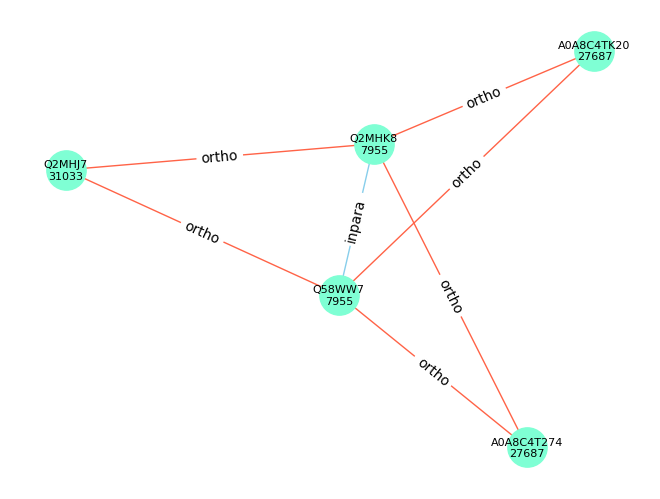

In [17]:
sub = G2.subgraph(cc[1103])
pos = nx.spring_layout(sub, seed=42)

edge_colors = [
    "tomato" if data.get("label") == "ortho" else "skyblue"
    for u, v, data in sub.edges(data=True)
]

nx.draw(
    sub,
    pos,
    edge_color= edge_colors,
    node_color="aquamarine",
    node_size=800,
    font_size=8
)

edge_labels = nx.get_edge_attributes(sub, "label")
nx.draw_networkx_edge_labels(sub, pos, edge_labels=edge_labels, font_color="black")

node_labels = nx.get_node_attributes(sub, "taxid")
merged_labels = {n: f"{n}\n{attr}" for n, attr in node_labels.items()}
nx.draw_networkx_labels(sub, pos, labels=merged_labels, font_size=8)

plt.show()

Score de probabilité de lien le + élevé : entre A0A8C4T20 et A0A8C4T274